In [1]:
import numpy as np
import pymesh
from glob import glob
from sklearn import preprocessing
import math
import pandas as pd

In [2]:
def distance2D(a, b):
    return math.sqrt( ((b[0]-a[0])**2)  + ((b[1]-a[1])**2) )

In [3]:
fs_mesh = np.array(sorted(glob("./out/torsos_smooth/*.ply")))

In [4]:
# fetas =[]
# for mesh_f in fs_mesh[47:48]:
#     fetas_i = [str(i)+"-feta-"+mesh_f.split("/")[-1]+".ply" for i in range(0,50)]
#     mesh_torso = pymesh.load_mesh(mesh_f) 
#     medidas = []
#     #print mesh_f
#     for f in fetas_i[36:39]:
#         mesh = pymesh.load_mesh("./out/fetas/"+f)
#         print "./out/fetas/"+f
#         output_mesh = pymesh.boolean(mesh_torso, mesh, operation="intersection",engine="auto")
#         print np.shape(output_mesh.vertices)[0]
#         if np.shape(output_mesh.vertices)[0] == 0:
#             print mesh_f
#             np.shape(output_mesh.vertices)[0]
#         pymesh.save_mesh("./out/fetas_reales/"+f,output_mesh)
#         #print(aux)
#     print "------------------------------"

In [5]:
fetas =[]
for mesh_f in fs_mesh[:]:
    fetas_i = [str(i)+"-feta-"+mesh_f.split("/")[-1]+".ply" for i in range(0,50)]
    #mesh_torso = pymesh.load_mesh(mesh_f) 
    medidas = []
    print mesh_f
    if mesh_f == "./out/torsos_smooth/model_mesh_062.ply" or mesh_f == "./out/torsos_smooth/model_mesh_076.ply" or mesh_f == "./out/torsos_smooth/model_mesh_108.ply" or  mesh_f == "./out/torsos_smooth/model_mesh_149.ply":
        print("omitido")
        continue
    for f in fetas_i:
        mesh = pymesh.load_mesh("./out/fetas_reales/"+f)
        #print "./out/fetas_reales/"+f
        #output_mesh = pymesh.boolean(mesh_torso, mesh, operation="intersection",engine="auto")
        vertexs_2d = np.delete(mesh.vertices, [1], axis=1)
        #del(mesh)
        medidas.append(vertexs_2d)
    fetas.append(medidas)
        #print(aux)

./out/torsos_smooth/model_mesh_001.ply
./out/torsos_smooth/model_mesh_002.ply
./out/torsos_smooth/model_mesh_004.ply
./out/torsos_smooth/model_mesh_005.ply
./out/torsos_smooth/model_mesh_006.ply
./out/torsos_smooth/model_mesh_009.ply
./out/torsos_smooth/model_mesh_010.ply
./out/torsos_smooth/model_mesh_011.ply
./out/torsos_smooth/model_mesh_012.ply
./out/torsos_smooth/model_mesh_013.ply
./out/torsos_smooth/model_mesh_015.ply
./out/torsos_smooth/model_mesh_016.ply
./out/torsos_smooth/model_mesh_017.ply
./out/torsos_smooth/model_mesh_018.ply
./out/torsos_smooth/model_mesh_019.ply
./out/torsos_smooth/model_mesh_020.ply
./out/torsos_smooth/model_mesh_021.ply
./out/torsos_smooth/model_mesh_024.ply
./out/torsos_smooth/model_mesh_025.ply
./out/torsos_smooth/model_mesh_026.ply
./out/torsos_smooth/model_mesh_028.ply
./out/torsos_smooth/model_mesh_030.ply
./out/torsos_smooth/model_mesh_033.ply
./out/torsos_smooth/model_mesh_034.ply
./out/torsos_smooth/model_mesh_035.ply
./out/torsos_smooth/model

In [6]:
np.shape(fetas)

(113, 50)

In [7]:
def lin_refine_implicit(x, n):
    """
    Given a 2D ndarray (npt, m) of npt coordinates in m dimension, insert 2**(n-1) additional points on each trajectory segment
    Returns an (npt*2**(n-1), m) ndarray
    """
    if n > 1:
        m = 0.5*(x[:-1] + x[1:])
        if x.ndim == 2:
            msize = (x.shape[0] + m.shape[0], x.shape[1])
        else:
            raise NotImplementedError

        x_new = np.empty(msize, dtype=x.dtype)
        x_new[0::2] = x
        x_new[1::2] = m
        return lin_refine_implicit(x_new, n-1)
    elif n == 1:
        return x
    else:
        raise ValueError


In [8]:
indi_values = []
for i in fetas[:]:
    values = []
    for j in i:
        vertexs_2d = j
        mx = np.mean(vertexs_2d[:,0])
        my = np.mean(vertexs_2d[:,1])
        vertexs_2d = np.array(sorted(vertexs_2d, key=lambda x : (math.atan2(x[0] - mx, x[1] - my) + 2 * math.pi) % (2*math.pi)))
        xy = np.vstack((vertexs_2d[:,0], vertexs_2d[:,1])).T
        xy_highres_lin = lin_refine_implicit(xy, n=3)
        n=2420
        xy= xy.flatten()
        xy_highres_lin= xy_highres_lin.flatten()
        zro = np.zeros(n)
        zro[:xy.shape[0]] = xy
        zro = zro.reshape((zro.shape[0]/2,2))
        xy_highres_lin = xy_highres_lin.reshape((xy_highres_lin.shape[0]/2,2))
        zro[xy.shape[0]/2:n/2] = xy_highres_lin[np.random.randint(xy_highres_lin.shape[0],size=abs(n/2 - xy.shape[0]/2))]
        mx = np.mean(zro[:,0])
        my = np.mean(zro[:,1])
        vertexs_2d = np.array(sorted(zro, key=lambda x : (math.atan2(x[0] - mx, x[1] - my) + 2 * math.pi) % (2*math.pi)))
        values.append(np.array(vertexs_2d).flatten())
    indi_values.append(np.array(values).flatten())

In [9]:
np.shape(indi_values)

(113, 121000)

In [10]:
fetas_outl = np.array(indi_values)

In [11]:
fetas_outl.shape

(113, 121000)

In [12]:
from sklearn import decomposition

In [13]:
pca = decomposition.PCA(n_components=70,svd_solver='full')
pca.fit(fetas_outl)
print "Con n_components = {} el valor es: {} ".format(76,pca.explained_variance_ratio_.sum())

Con n_components = 76 el valor es: 0.974487373383 


In [14]:
x_out = pca.transform(fetas_outl)
x_out.shape

(113, 70)

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [16]:
#ids = ["002","004","001","005","006","009","010","011","012","013","015","016","017","018","019","020","021","024","025","026","028","030","033","034","035","036","038","039","041","042","043","044","045","046","047","048","049","050","051","052","053","054","055","056","058","059","061","063","064","065","067","069","070","071","073","074","075","078","079","080","081","082","084","085","086","087","088","089","090","091","092","094","097","098","100","101","103","104","105","106","107","108","110","112","113","114","115","117","118","120","121","122","123","124","125","127","128","130","135","136","137","138","139","141","142","143","145","146","147","148","149","150","151","153","154"]
ids = ["002","004","001","005","006","009","010","011","012","013","015","016","017","018","019","020","021","024","025","026","028","030","033","034","035","036","038","039","041","042","043","044","045","046","047","048","049","050","051","052","053","054","055","056","058","059","061","063","064","065","067","069","070","071","073","074","075","078","079","080","081","082","084","085","086","087","088","089","090","091","092","094","097","098","100","101","103","104","105","106","107","110","112","113","114","115","117","118","120","121","122","123","124","125","127","128","130","135","136","137","138","139","141","142","143","145","146","147","148","150","151","153","154"]

In [17]:
np.shape(ids)

(113,)

In [18]:
ids_utilizados = map(lambda x: int(x),ids)

In [19]:
data = pd.read_excel("./planilla_colecta.xlsx")

In [20]:
data = data[data['id'].isin(ids_utilizados)]

In [21]:
def bmi_cal(bmi):
    if 18.5 > bmi:
        return "underfat"
    if 18.5 <= bmi < 25:
        return "healthy"
    if 25 <= bmi < 30:
        return "overfat"
    if 30 <= bmi:
        return "obese"

In [22]:
sexo = data["sexo"].iloc[:].tolist() 
body_fat_range = data["Body fat range"].iloc[:].tolist() 
peso = data["peso"].iloc[:].tolist() 
altura = data["promedio altura"].iloc[:].tolist() 

In [23]:
altura = np.array(altura)/100

In [24]:
bmis = map( lambda pa: bmi_cal(pa[0] / (pa[1]*pa[1]))  ,zip(peso,altura))

In [25]:
(peso[0] / (altura[0]*altura[0]))

23.333717859020894

In [26]:
peso[0]

62.3

In [27]:
altura[0]

1.6340000000000001

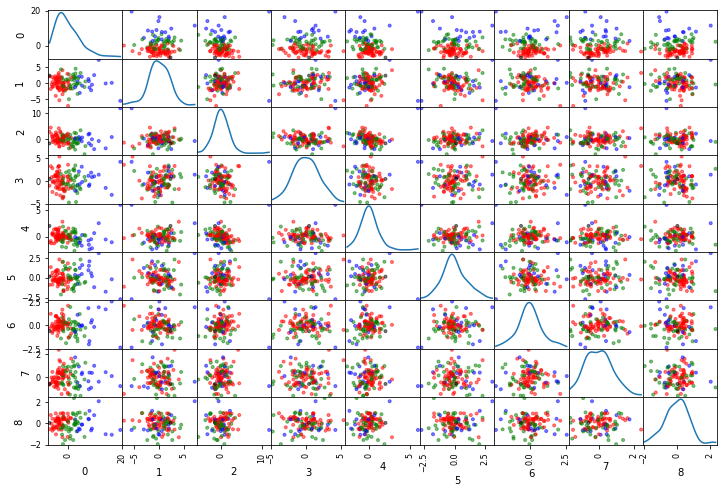

In [28]:
interest_feat = range(10)
data = pd.DataFrame(x_out)
data["labels"]= bmis
color_wheel = {"healthy": "red", "obese": "blue","overfat":"green","underfat":"black","desconocido":"yellow"}
colors = data["labels"].map(lambda x: color_wheel.get(x.lower()))
pd.scatter_matrix(data.loc[:,interest_feat[:-1]], figsize=(12,8), diagonal='kde',label=data.loc[:,"labels"],c=colors)
#pd.scatter_matrix(data.loc[:,interest_feat[:-1]], figsize=(12,8), diagonal='kde')
plt.show()

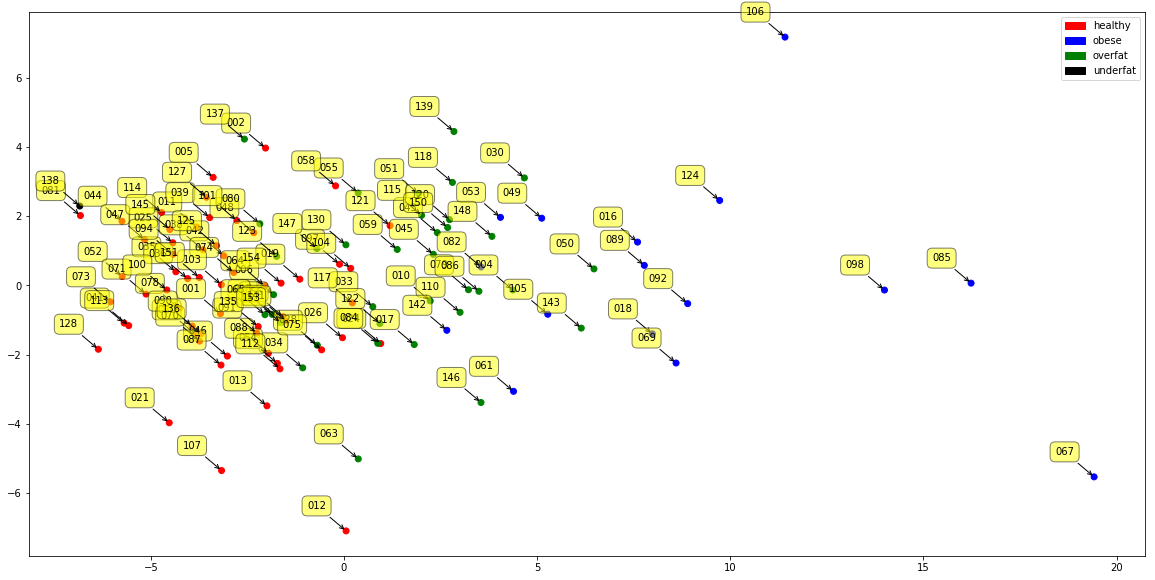

In [34]:
import matplotlib.patches as mpatches

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x_out[:,0],x_out[:,1],c=colors,marker="o")
plt.rcParams["figure.figsize"] = [20,10]

red_patch = mpatches.Patch(color='red', label='healthy')
green_patch = mpatches.Patch(color='green', label='overfat')
blue_patch = mpatches.Patch(color='blue', label='obese')
black_patch = mpatches.Patch(color='black', label='underfat')
plt.legend(handles=[red_patch,blue_patch,green_patch,black_patch])


#ax.scatter(x_out[:,0],x_out[:,1],marker="o")



# for label, x, y in zip(np.array(ids)[fat_class], x_out[fat_class,7], x_out[fat_class,0]):
#     plt.annotate(
#         label,
#         xy=(x, y), xytext=(-20, 20),
#         textcoords='offset points', ha='right', va='bottom',
#         bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
#         arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    
# for label, x, y in zip(np.array(ids), x_out[:,0], x_out[:,1]):
#     plt.annotate(
#         label,
#         xy=(x, y), xytext=(-20, 20),
#         textcoords='offset points', ha='right', va='bottom',
#         bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
#         arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

for label, x, y in zip(np.array(ids), x_out[:,0], x_out[:,1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.legend(loc='best')

plt.show()

In [ ]:
pca.explained_variance_

# Prediciendo

In [ ]:
import sklearn
from sklearn.svm import SVC

In [ ]:
id_bmi = {"healthy": 0, "obese": 1, "underfat":0, "overfat": 1}
bmi_c = data["labels"].map(lambda x: id_bmi.get(x)).tolist()

In [ ]:
X = x_out
y = bmi_c

In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split( X, y, test_size=0.30, random_state=42)

In [ ]:
clf = SVC()
clf.fit(X_train, y_train) 

In [ ]:
clf.score(X_test,y_test)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report
clf = ExtraTreesClassifier(n_estimators=200,
                           max_features=0.3,
                           #max_depth=4, #20
                           random_state=1).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

In [ ]:
clf.score(X_test,y_test)

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=5)

In [ ]:
scores.mean()

In [ ]:
scores.std()

In [ ]:
scores

In [ ]:
clf.score?